<a href="https://colab.research.google.com/github/moneshj/Cow-classification/blob/main/Plastics_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reference Paper's :


*   https://www.researchgate.net/publication/351797845_Detection_of_Plastic_Greenhouses_Using_High_Resolution_Rgb_Remote_Sensing_Data_and_Convolutional_Neural_Network
*  https://www.sciencedirect.com/science/article/pii/S0303243421001483



#Plastic :1  antiplasti/Plastic-Detection-Model

In [ ]:
!git clone https://github.com/antiplasti/Plastic-Detection-Model.git

Cloning into 'Plastic-Detection-Model'...
remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 119 (delta 0), reused 1 (delta 0), pack-reused 115
Receiving objects: 100% (119/119), 42.76 MiB | 34.18 MiB/s, done.
Resolving deltas: 100% (61/61), done.


In [ ]:
!unzip /content/Plastic-Detection-Model/training_dataset.zip


In [ ]:
!/content/Plastic-Detection-Model/train.sh

/bin/bash: /content/Plastic-Detection-Model/train.sh: Permission denied


In [ ]:
cd Plastic-Detection-Model/

[Errno 2] No such file or directory: 'Plastic-Detection-Model/'
/root


In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
from datetime import datetime
import hashlib
import os.path
import random
import re
import struct
import sys
import tarfile

import numpy as np
from six.moves import urllib
import tensorflow as tf

from tensorflow.python.framework import graph_util
from tensorflow.python.framework import tensor_shape
from tensorflow.python.platform import gfile
from tensorflow.python.util import compat

FLAGS = None

# These are all parameters that are tied to the particular model architecture
# we're using for Inception v3. These include things like tensor names and their
# sizes. If you want to adapt this script to work with another model, you will
# need to update these to reflect the values in the network you're using.
# pylint: disable=line-too-long
DATA_URL = 'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz'
# pylint: enable=line-too-long
BOTTLENECK_TENSOR_NAME = 'pool_3/_reshape:0'
BOTTLENECK_TENSOR_SIZE = 2048
MODEL_INPUT_WIDTH = 299
MODEL_INPUT_HEIGHT = 299
MODEL_INPUT_DEPTH = 3
JPEG_DATA_TENSOR_NAME = 'DecodeJpeg/contents:0'
RESIZED_INPUT_TENSOR_NAME = 'ResizeBilinear:0'
MAX_NUM_IMAGES_PER_CLASS = 2 ** 27 - 1  # ~134M


def create_image_lists(image_dir, testing_percentage, validation_percentage):
  """Builds a list of training images from the file system.

  Analyzes the sub folders in the image directory, splits them into stable
  training, testing, and validation sets, and returns a data structure
  describing the lists of images for each label and their paths.

  Args:
    image_dir: String path to a folder containing subfolders of images.
    testing_percentage: Integer percentage of the images to reserve for tests.
    validation_percentage: Integer percentage of images reserved for validation.

  Returns:
    A dictionary containing an entry for each label subfolder, with images split
    into training, testing, and validation sets within each label.
  """
  if not gfile.Exists(image_dir):
    print("Image directory '" + image_dir + "' not found.")
    return None
  result = {}
  sub_dirs = [x[0] for x in gfile.Walk(image_dir)]
  # The root directory comes first, so skip it.
  is_root_dir = True
  for sub_dir in sub_dirs:
    if is_root_dir:
      is_root_dir = False
      continue
    extensions = ['jpg', 'jpeg', 'JPG', 'JPEG']
    file_list = []
    dir_name = os.path.basename(sub_dir)
    if dir_name == image_dir:
      continue
    print("Looking for images in '" + dir_name + "'")
    for extension in extensions:
      file_glob = os.path.join(image_dir, dir_name, '*.' + extension)
      file_list.extend(gfile.Glob(file_glob))
    if not file_list:
      print('No files found')
      continue
    if len(file_list) < 20:
      print('WARNING: Folder has less than 20 images, which may cause issues.')
    elif len(file_list) > MAX_NUM_IMAGES_PER_CLASS:
      print('WARNING: Folder {} has more than {} images. Some images will '
            'never be selected.'.format(dir_name, MAX_NUM_IMAGES_PER_CLASS))
    label_name = re.sub(r'[^a-z0-9]+', ' ', dir_name.lower())
    training_images = []
    testing_images = []
    validation_images = []
    for file_name in file_list:
      base_name = os.path.basename(file_name)
      # We want to ignore anything after '_nohash_' in the file name when
      # deciding which set to put an image in, the data set creator has a way of
      # grouping photos that are close variations of each other. For example
      # this is used in the plant disease data set to group multiple pictures of
      # the same leaf.
      hash_name = re.sub(r'_nohash_.*$', '', file_name)
      # This looks a bit magical, but we need to decide whether this file should
      # go into the training, testing, or validation sets, and we want to keep
      # existing files in the same set even if more files are subsequently
      # added.
      # To do that, we need a stable way of deciding based on just the file name
      # itself, so we do a hash of that and then use that to generate a
      # probability value that we use to assign it.
      hash_name_hashed = hashlib.sha1(compat.as_bytes(hash_name)).hexdigest()
      percentage_hash = ((int(hash_name_hashed, 16) %
                          (MAX_NUM_IMAGES_PER_CLASS + 1)) *
                         (100.0 / MAX_NUM_IMAGES_PER_CLASS))
      if percentage_hash < validation_percentage:
        validation_images.append(base_name)
      elif percentage_hash < (testing_percentage + validation_percentage):
        testing_images.append(base_name)
      else:
        training_images.append(base_name)
    result[label_name] = {
        'dir': dir_name,
        'training': training_images,
        'testing': testing_images,
        'validation': validation_images,
    }
  return result


def get_image_path(image_lists, label_name, index, image_dir, category):
  """"Returns a path to an image for a label at the given index.

  Args:
    image_lists: Dictionary of training images for each label.
    label_name: Label string we want to get an image for.
    index: Int offset of the image we want. This will be moduloed by the
    available number of images for the label, so it can be arbitrarily large.
    image_dir: Root folder string of the subfolders containing the training
    images.
    category: Name string of set to pull images from - training, testing, or
    validation.

  Returns:
    File system path string to an image that meets the requested parameters.

  """
  if label_name not in image_lists:
    tf.logging.fatal('Label does not exist %s.', label_name)
  label_lists = image_lists[label_name]
  if category not in label_lists:
    tf.logging.fatal('Category does not exist %s.', category)
  category_list = label_lists[category]
  if not category_list:
    tf.logging.fatal('Label %s has no images in the category %s.',
                     label_name, category)
  mod_index = index % len(category_list)
  base_name = category_list[mod_index]
  sub_dir = label_lists['dir']
  full_path = os.path.join(image_dir, sub_dir, base_name)
  return full_path


def get_bottleneck_path(image_lists, label_name, index, bottleneck_dir,
                        category):
  """"Returns a path to a bottleneck file for a label at the given index.

  Args:
    image_lists: Dictionary of training images for each label.
    label_name: Label string we want to get an image for.
    index: Integer offset of the image we want. This will be moduloed by the
    available number of images for the label, so it can be arbitrarily large.
    bottleneck_dir: Folder string holding cached files of bottleneck values.
    category: Name string of set to pull images from - training, testing, or
    validation.

  Returns:
    File system path string to an image that meets the requested parameters.
  """
  return get_image_path(image_lists, label_name, index, bottleneck_dir,
                        category) + '.txt'


def create_inception_graph():
  """"Creates a graph from saved GraphDef file and returns a Graph object.

  Returns:
    Graph holding the trained Inception network, and various tensors we'll be
    manipulating.
  """
  with tf.Graph().as_default() as graph:
    model_filename = os.path.join(
        FLAGS.model_dir, 'classify_image_graph_def.pb')
    with gfile.FastGFile(model_filename, 'rb') as f:
      graph_def = tf.GraphDef()
      graph_def.ParseFromString(f.read())
      bottleneck_tensor, jpeg_data_tensor, resized_input_tensor = (
          tf.import_graph_def(graph_def, name='', return_elements=[
              BOTTLENECK_TENSOR_NAME, JPEG_DATA_TENSOR_NAME,
              RESIZED_INPUT_TENSOR_NAME]))
  return graph, bottleneck_tensor, jpeg_data_tensor, resized_input_tensor


def run_bottleneck_on_image(sess, image_data, image_data_tensor,
                            bottleneck_tensor):
  """Runs inference on an image to extract the 'bottleneck' summary layer.

  Args:
    sess: Current active TensorFlow Session.
    image_data: String of raw JPEG data.
    image_data_tensor: Input data layer in the graph.
    bottleneck_tensor: Layer before the final softmax.

  Returns:
    Numpy array of bottleneck values.
  """
  bottleneck_values = sess.run(
      bottleneck_tensor,
      {image_data_tensor: image_data})
  bottleneck_values = np.squeeze(bottleneck_values)
  return bottleneck_values


def maybe_download_and_extract():
  """Download and extract model tar file.

  If the pretrained model we're using doesn't already exist, this function
  downloads it from the TensorFlow.org website and unpacks it into a directory.
  """
  dest_directory = FLAGS.model_dir
  if not os.path.exists(dest_directory):
    os.makedirs(dest_directory)
  filename = DATA_URL.split('/')[-1]
  filepath = os.path.join(dest_directory, filename)
  if not os.path.exists(filepath):

    def _progress(count, block_size, total_size):
      sys.stdout.write('\r>> Downloading %s %.1f%%' %
                       (filename,
                        float(count * block_size) / float(total_size) * 100.0))
      sys.stdout.flush()

    filepath, _ = urllib.request.urlretrieve(DATA_URL,
                                             filepath,
                                             _progress)
    print()
    statinfo = os.stat(filepath)
    print('Successfully downloaded', filename, statinfo.st_size, 'bytes.')
  tarfile.open(filepath, 'r:gz').extractall(dest_directory)


def ensure_dir_exists(dir_name):
  """Makes sure the folder exists on disk.

  Args:
    dir_name: Path string to the folder we want to create.
  """
  if not os.path.exists(dir_name):
    os.makedirs(dir_name)


def write_list_of_floats_to_file(list_of_floats, file_path):
  """Writes a given list of floats to a binary file.

  Args:
    list_of_floats: List of floats we want to write to a file.
    file_path: Path to a file where list of floats will be stored.

  """

  s = struct.pack('d' * BOTTLENECK_TENSOR_SIZE, *list_of_floats)
  with open(file_path, 'wb') as f:
    f.write(s)


def read_list_of_floats_from_file(file_path):
  """Reads list of floats from a given file.

  Args:
    file_path: Path to a file where list of floats was stored.
  Returns:
    Array of bottleneck values (list of floats).

  """

  with open(file_path, 'rb') as f:
    s = struct.unpack('d' * BOTTLENECK_TENSOR_SIZE, f.read())
    return list(s)


bottleneck_path_2_bottleneck_values = {}


def create_bottleneck_file(bottleneck_path, image_lists, label_name, index,
                           image_dir, category, sess, jpeg_data_tensor,
                           bottleneck_tensor):
  """Create a single bottleneck file."""
  print('Creating bottleneck at ' + bottleneck_path)
  image_path = get_image_path(image_lists, label_name, index,
                              image_dir, category)
  if not gfile.Exists(image_path):
    tf.logging.fatal('File does not exist %s', image_path)
  image_data = gfile.FastGFile(image_path, 'rb').read()
  try:
    bottleneck_values = run_bottleneck_on_image(
        sess, image_data, jpeg_data_tensor, bottleneck_tensor)
  except:
    raise RuntimeError('Error during processing file %s' % image_path)

  bottleneck_string = ','.join(str(x) for x in bottleneck_values)
  with open(bottleneck_path, 'w') as bottleneck_file:
    bottleneck_file.write(bottleneck_string)


def get_or_create_bottleneck(sess, image_lists, label_name, index, image_dir,
                             category, bottleneck_dir, jpeg_data_tensor,
                             bottleneck_tensor):
  """Retrieves or calculates bottleneck values for an image.

  If a cached version of the bottleneck data exists on-disk, return that,
  otherwise calculate the data and save it to disk for future use.

  Args:
    sess: The current active TensorFlow Session.
    image_lists: Dictionary of training images for each label.
    label_name: Label string we want to get an image for.
    index: Integer offset of the image we want. This will be modulo-ed by the
    available number of images for the label, so it can be arbitrarily large.
    image_dir: Root folder string  of the subfolders containing the training
    images.
    category: Name string of which  set to pull images from - training, testing,
    or validation.
    bottleneck_dir: Folder string holding cached files of bottleneck values.
    jpeg_data_tensor: The tensor to feed loaded jpeg data into.
    bottleneck_tensor: The output tensor for the bottleneck values.

  Returns:
    Numpy array of values produced by the bottleneck layer for the image.
  """
  label_lists = image_lists[label_name]
  sub_dir = label_lists['dir']
  sub_dir_path = os.path.join(bottleneck_dir, sub_dir)
  ensure_dir_exists(sub_dir_path)
  bottleneck_path = get_bottleneck_path(image_lists, label_name, index,
                                        bottleneck_dir, category)
  if not os.path.exists(bottleneck_path):
    create_bottleneck_file(bottleneck_path, image_lists, label_name, index,
                           image_dir, category, sess, jpeg_data_tensor,
                           bottleneck_tensor)
  with open(bottleneck_path, 'r') as bottleneck_file:
    bottleneck_string = bottleneck_file.read()
  did_hit_error = False
  try:
    bottleneck_values = [float(x) for x in bottleneck_string.split(',')]
  except ValueError:
    print('Invalid float found, recreating bottleneck')
    did_hit_error = True
  if did_hit_error:
    create_bottleneck_file(bottleneck_path, image_lists, label_name, index,
                           image_dir, category, sess, jpeg_data_tensor,
                           bottleneck_tensor)
    with open(bottleneck_path, 'r') as bottleneck_file:
      bottleneck_string = bottleneck_file.read()
    # Allow exceptions to propagate here, since they shouldn't happen after a
    # fresh creation
    bottleneck_values = [float(x) for x in bottleneck_string.split(',')]
  return bottleneck_values


def cache_bottlenecks(sess, image_lists, image_dir, bottleneck_dir,
                      jpeg_data_tensor, bottleneck_tensor):
  """Ensures all the training, testing, and validation bottlenecks are cached.

  Because we're likely to read the same image multiple times (if there are no
  distortions applied during training) it can speed things up a lot if we
  calculate the bottleneck layer values once for each image during
  preprocessing, and then just read those cached values repeatedly during
  training. Here we go through all the images we've found, calculate those
  values, and save them off.

  Args:
    sess: The current active TensorFlow Session.
    image_lists: Dictionary of training images for each label.
    image_dir: Root folder string of the subfolders containing the training
    images.
    bottleneck_dir: Folder string holding cached files of bottleneck values.
    jpeg_data_tensor: Input tensor for jpeg data from file.
    bottleneck_tensor: The penultimate output layer of the graph.

  Returns:
    Nothing.
  """
  how_many_bottlenecks = 0
  ensure_dir_exists(bottleneck_dir)
  for label_name, label_lists in image_lists.items():
    for category in ['training', 'testing', 'validation']:
      category_list = label_lists[category]
      for index, unused_base_name in enumerate(category_list):
        get_or_create_bottleneck(sess, image_lists, label_name, index,
                                 image_dir, category, bottleneck_dir,
                                 jpeg_data_tensor, bottleneck_tensor)

        how_many_bottlenecks += 1
        if how_many_bottlenecks % 100 == 0:
          print(str(how_many_bottlenecks) + ' bottleneck files created.')


def get_random_cached_bottlenecks(sess, image_lists, how_many, category,
                                  bottleneck_dir, image_dir, jpeg_data_tensor,
                                  bottleneck_tensor):
  """Retrieves bottleneck values for cached images.

  If no distortions are being applied, this function can retrieve the cached
  bottleneck values directly from disk for images. It picks a random set of
  images from the specified category.

  Args:
    sess: Current TensorFlow Session.
    image_lists: Dictionary of training images for each label.
    how_many: If positive, a random sample of this size will be chosen.
    If negative, all bottlenecks will be retrieved.
    category: Name string of which set to pull from - training, testing, or
    validation.
    bottleneck_dir: Folder string holding cached files of bottleneck values.
    image_dir: Root folder string of the subfolders containing the training
    images.
    jpeg_data_tensor: The layer to feed jpeg image data into.
    bottleneck_tensor: The bottleneck output layer of the CNN graph.

  Returns:
    List of bottleneck arrays, their corresponding ground truths, and the
    relevant filenames.
  """
  class_count = len(image_lists.keys())
  bottlenecks = []
  ground_truths = []
  filenames = []
  if how_many >= 0:
    # Retrieve a random sample of bottlenecks.
    for unused_i in range(how_many):
      label_index = random.randrange(class_count)
      label_name = list(image_lists.keys())[label_index]
      image_index = random.randrange(MAX_NUM_IMAGES_PER_CLASS + 1)
      image_name = get_image_path(image_lists, label_name, image_index,
                                  image_dir, category)
      bottleneck = get_or_create_bottleneck(sess, image_lists, label_name,
                                            image_index, image_dir, category,
                                            bottleneck_dir, jpeg_data_tensor,
                                            bottleneck_tensor)
      ground_truth = np.zeros(class_count, dtype=np.float32)
      ground_truth[label_index] = 1.0
      bottlenecks.append(bottleneck)
      ground_truths.append(ground_truth)
      filenames.append(image_name)
  else:
    # Retrieve all bottlenecks.
    for label_index, label_name in enumerate(image_lists.keys()):
      for image_index, image_name in enumerate(
          image_lists[label_name][category]):
        image_name = get_image_path(image_lists, label_name, image_index,
                                    image_dir, category)
        bottleneck = get_or_create_bottleneck(sess, image_lists, label_name,
                                              image_index, image_dir, category,
                                              bottleneck_dir, jpeg_data_tensor,
                                              bottleneck_tensor)
        ground_truth = np.zeros(class_count, dtype=np.float32)
        ground_truth[label_index] = 1.0
        bottlenecks.append(bottleneck)
        ground_truths.append(ground_truth)
        filenames.append(image_name)
  return bottlenecks, ground_truths, filenames


def get_random_distorted_bottlenecks(
    sess, image_lists, how_many, category, image_dir, input_jpeg_tensor,
    distorted_image, resized_input_tensor, bottleneck_tensor):
  """Retrieves bottleneck values for training images, after distortions.

  If we're training with distortions like crops, scales, or flips, we have to
  recalculate the full model for every image, and so we can't use cached
  bottleneck values. Instead we find random images for the requested category,
  run them through the distortion graph, and then the full graph to get the
  bottleneck results for each.

  Args:
    sess: Current TensorFlow Session.
    image_lists: Dictionary of training images for each label.
    how_many: The integer number of bottleneck values to return.
    category: Name string of which set of images to fetch - training, testing,
    or validation.
    image_dir: Root folder string of the subfolders containing the training
    images.
    input_jpeg_tensor: The input layer we feed the image data to.
    distorted_image: The output node of the distortion graph.
    resized_input_tensor: The input node of the recognition graph.
    bottleneck_tensor: The bottleneck output layer of the CNN graph.

  Returns:
    List of bottleneck arrays and their corresponding ground truths.
  """
  class_count = len(image_lists.keys())
  bottlenecks = []
  ground_truths = []
  for unused_i in range(how_many):
    label_index = random.randrange(class_count)
    label_name = list(image_lists.keys())[label_index]
    image_index = random.randrange(MAX_NUM_IMAGES_PER_CLASS + 1)
    image_path = get_image_path(image_lists, label_name, image_index, image_dir,
                                category)
    if not gfile.Exists(image_path):
      tf.logging.fatal('File does not exist %s', image_path)
    jpeg_data = gfile.FastGFile(image_path, 'rb').read()
    # Note that we materialize the distorted_image_data as a numpy array before
    # sending running inference on the image. This involves 2 memory copies and
    # might be optimized in other implementations.
    distorted_image_data = sess.run(distorted_image,
                                    {input_jpeg_tensor: jpeg_data})
    bottleneck = run_bottleneck_on_image(sess, distorted_image_data,
                                         resized_input_tensor,
                                         bottleneck_tensor)
    ground_truth = np.zeros(class_count, dtype=np.float32)
    ground_truth[label_index] = 1.0
    bottlenecks.append(bottleneck)
    ground_truths.append(ground_truth)
  return bottlenecks, ground_truths


def should_distort_images(flip_left_right, random_crop, random_scale,
                          random_brightness):
  """Whether any distortions are enabled, from the input flags.

  Args:
    flip_left_right: Boolean whether to randomly mirror images horizontally.
    random_crop: Integer percentage setting the total margin used around the
    crop box.
    random_scale: Integer percentage of how much to vary the scale by.
    random_brightness: Integer range to randomly multiply the pixel values by.

  Returns:
    Boolean value indicating whether any distortions should be applied.
  """
  return (flip_left_right or (random_crop != 0) or (random_scale != 0) or
          (random_brightness != 0))


def add_input_distortions(flip_left_right, random_crop, random_scale,
                          random_brightness):
  """Creates the operations to apply the specified distortions.

  During training it can help to improve the results if we run the images
  through simple distortions like crops, scales, and flips. These reflect the
  kind of variations we expect in the real world, and so can help train the
  model to cope with natural data more effectively. Here we take the supplied
  parameters and construct a network of operations to apply them to an image.

  Cropping
  ~~~~~~~~

  Cropping is done by placing a bounding box at a random position in the full
  image. The cropping parameter controls the size of that box relative to the
  input image. If it's zero, then the box is the same size as the input and no
  cropping is performed. If the value is 50%, then the crop box will be half the
  width and height of the input. In a diagram it looks like this:

  <       width         >
  +---------------------+
  |                     |
  |   width - crop%     |
  |    <      >         |
  |    +------+         |
  |    |      |         |
  |    |      |         |
  |    |      |         |
  |    +------+         |
  |                     |
  |                     |
  +---------------------+

  Scaling
  ~~~~~~~

  Scaling is a lot like cropping, except that the bounding box is always
  centered and its size varies randomly within the given range. For example if
  the scale percentage is zero, then the bounding box is the same size as the
  input and no scaling is applied. If it's 50%, then the bounding box will be in
  a random range between half the width and height and full size.

  Args:
    flip_left_right: Boolean whether to randomly mirror images horizontally.
    random_crop: Integer percentage setting the total margin used around the
    crop box.
    random_scale: Integer percentage of how much to vary the scale by.
    random_brightness: Integer range to randomly multiply the pixel values by.
    graph.

  Returns:
    The jpeg input layer and the distorted result tensor.
  """

  jpeg_data = tf.placeholder(tf.string, name='DistortJPGInput')
  decoded_image = tf.image.decode_jpeg(jpeg_data, channels=MODEL_INPUT_DEPTH)
  decoded_image_as_float = tf.cast(decoded_image, dtype=tf.float32)
  decoded_image_4d = tf.expand_dims(decoded_image_as_float, 0)
  margin_scale = 1.0 + (random_crop / 100.0)
  resize_scale = 1.0 + (random_scale / 100.0)
  margin_scale_value = tf.constant(margin_scale)
  resize_scale_value = tf.random_uniform(tensor_shape.scalar(),
                                         minval=1.0,
                                         maxval=resize_scale)
  scale_value = tf.multiply(margin_scale_value, resize_scale_value)
  precrop_width = tf.multiply(scale_value, MODEL_INPUT_WIDTH)
  precrop_height = tf.multiply(scale_value, MODEL_INPUT_HEIGHT)
  precrop_shape = tf.stack([precrop_height, precrop_width])
  precrop_shape_as_int = tf.cast(precrop_shape, dtype=tf.int32)
  precropped_image = tf.image.resize_bilinear(decoded_image_4d,
                                              precrop_shape_as_int)
  precropped_image_3d = tf.squeeze(precropped_image, squeeze_dims=[0])
  cropped_image = tf.random_crop(precropped_image_3d,
                                 [MODEL_INPUT_HEIGHT, MODEL_INPUT_WIDTH,
                                  MODEL_INPUT_DEPTH])
  if flip_left_right:
    flipped_image = tf.image.random_flip_left_right(cropped_image)
  else:
    flipped_image = cropped_image
  brightness_min = 1.0 - (random_brightness / 100.0)
  brightness_max = 1.0 + (random_brightness / 100.0)
  brightness_value = tf.random_uniform(tensor_shape.scalar(),
                                       minval=brightness_min,
                                       maxval=brightness_max)
  brightened_image = tf.multiply(flipped_image, brightness_value)
  distort_result = tf.expand_dims(brightened_image, 0, name='DistortResult')
  return jpeg_data, distort_result


def variable_summaries(var):
  """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
  with tf.name_scope('summaries'):
    mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
      stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)


def add_final_training_ops(class_count, final_tensor_name, bottleneck_tensor):
  """Adds a new softmax and fully-connected layer for training.

  We need to retrain the top layer to identify our new classes, so this function
  adds the right operations to the graph, along with some variables to hold the
  weights, and then sets up all the gradients for the backward pass.

  The set up for the softmax and fully-connected layers is based on:
  https://tensorflow.org/versions/master/tutorials/mnist/beginners/index.html

  Args:
    class_count: Integer of how many categories of things we're trying to
    recognize.
    final_tensor_name: Name string for the new final node that produces results.
    bottleneck_tensor: The output of the main CNN graph.

  Returns:
    The tensors for the training and cross entropy results, and tensors for the
    bottleneck input and ground truth input.
  """
  with tf.name_scope('input'):
    bottleneck_input = tf.placeholder_with_default(
        bottleneck_tensor, shape=[None, BOTTLENECK_TENSOR_SIZE],
        name='BottleneckInputPlaceholder')

    ground_truth_input = tf.placeholder(tf.float32,
                                        [None, class_count],
                                        name='GroundTruthInput')

  # Organizing the following ops as `final_training_ops` so they're easier
  # to see in TensorBoard
  layer_name = 'final_training_ops'
  with tf.name_scope(layer_name):
    with tf.name_scope('weights'):
      initial_value = tf.truncated_normal([BOTTLENECK_TENSOR_SIZE, class_count],
                                          stddev=0.001)

      layer_weights = tf.Variable(initial_value, name='final_weights')

      variable_summaries(layer_weights)
    with tf.name_scope('biases'):
      layer_biases = tf.Variable(tf.zeros([class_count]), name='final_biases')
      variable_summaries(layer_biases)
    with tf.name_scope('Wx_plus_b'):
      logits = tf.matmul(bottleneck_input, layer_weights) + layer_biases
      tf.summary.histogram('pre_activations', logits)

  final_tensor = tf.nn.softmax(logits, name=final_tensor_name)
  tf.summary.histogram('activations', final_tensor)

  with tf.name_scope('cross_entropy'):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
        labels=ground_truth_input, logits=logits)
    with tf.name_scope('total'):
      cross_entropy_mean = tf.reduce_mean(cross_entropy)
  tf.summary.scalar('cross_entropy', cross_entropy_mean)

  with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(FLAGS.learning_rate)
    train_step = optimizer.minimize(cross_entropy_mean)

  return (train_step, cross_entropy_mean, bottleneck_input, ground_truth_input,
          final_tensor)


def add_evaluation_step(result_tensor, ground_truth_tensor):
  """Inserts the operations we need to evaluate the accuracy of our results.

  Args:
    result_tensor: The new final node that produces results.
    ground_truth_tensor: The node we feed ground truth data
    into.

  Returns:
    Tuple of (evaluation step, prediction).
  """
  with tf.name_scope('accuracy'):
    with tf.name_scope('correct_prediction'):
      prediction = tf.argmax(result_tensor, 1)
      correct_prediction = tf.equal(
          prediction, tf.argmax(ground_truth_tensor, 1))
    with tf.name_scope('accuracy'):
      evaluation_step = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
  tf.summary.scalar('accuracy', evaluation_step)
  return evaluation_step, prediction


def main(_):
  # Setup the directory we'll write summaries to for TensorBoard
  if tf.gfile.Exists(FLAGS.summaries_dir):
    tf.gfile.DeleteRecursively(FLAGS.summaries_dir)
  tf.gfile.MakeDirs(FLAGS.summaries_dir)

  # Set up the pre-trained graph.
  maybe_download_and_extract()
  graph, bottleneck_tensor, jpeg_data_tensor, resized_image_tensor = (
      create_inception_graph())

  # Look at the folder structure, and create lists of all the images.
  image_lists = create_image_lists(FLAGS.image_dir, FLAGS.testing_percentage,
                                   FLAGS.validation_percentage)
  class_count = len(image_lists.keys())
  if class_count == 0:
    print('No valid folders of images found at ' + FLAGS.image_dir)
    return -1
  if class_count == 1:
    print('Only one valid folder of images found at ' + FLAGS.image_dir +
          ' - multiple classes are needed for classification.')
    return -1

  # See if the command-line flags mean we're applying any distortions.
  do_distort_images = should_distort_images(
      FLAGS.flip_left_right, FLAGS.random_crop, FLAGS.random_scale,
      FLAGS.random_brightness)

  with tf.Session(graph=graph) as sess:

    if do_distort_images:
      # We will be applying distortions, so setup the operations we'll need.
      (distorted_jpeg_data_tensor,
       distorted_image_tensor) = add_input_distortions(
           FLAGS.flip_left_right, FLAGS.random_crop,
           FLAGS.random_scale, FLAGS.random_brightness)
    else:
      # We'll make sure we've calculated the 'bottleneck' image summaries and
      # cached them on disk.
      cache_bottlenecks(sess, image_lists, FLAGS.image_dir,
                        FLAGS.bottleneck_dir, jpeg_data_tensor,
                        bottleneck_tensor)

    # Add the new layer that we'll be training.
    (train_step, cross_entropy, bottleneck_input, ground_truth_input,
     final_tensor) = add_final_training_ops(len(image_lists.keys()),
                                            FLAGS.final_tensor_name,
                                            bottleneck_tensor)

    # Create the operations we need to evaluate the accuracy of our new layer.
    evaluation_step, prediction = add_evaluation_step(
        final_tensor, ground_truth_input)

    # Merge all the summaries and write them out to the summaries_dir
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(FLAGS.summaries_dir + '/train',
                                         sess.graph)

    validation_writer = tf.summary.FileWriter(
        FLAGS.summaries_dir + '/validation')

    # Set up all our weights to their initial default values.
    init = tf.global_variables_initializer()
    sess.run(init)

    # Run the training for as many cycles as requested on the command line.
    for i in range(FLAGS.how_many_training_steps):
      # Get a batch of input bottleneck values, either calculated fresh every
      # time with distortions applied, or from the cache stored on disk.
      if do_distort_images:
        (train_bottlenecks,
         train_ground_truth) = get_random_distorted_bottlenecks(
             sess, image_lists, FLAGS.train_batch_size, 'training',
             FLAGS.image_dir, distorted_jpeg_data_tensor,
             distorted_image_tensor, resized_image_tensor, bottleneck_tensor)
      else:
        (train_bottlenecks,
         train_ground_truth, _) = get_random_cached_bottlenecks(
             sess, image_lists, FLAGS.train_batch_size, 'training',
             FLAGS.bottleneck_dir, FLAGS.image_dir, jpeg_data_tensor,
             bottleneck_tensor)
      # Feed the bottlenecks and ground truth into the graph, and run a training
      # step. Capture training summaries for TensorBoard with the `merged` op.

      train_summary, _ = sess.run(
          [merged, train_step],
          feed_dict={bottleneck_input: train_bottlenecks,
                     ground_truth_input: train_ground_truth})
      train_writer.add_summary(train_summary, i)

      # Every so often, print out how well the graph is training.
      is_last_step = (i + 1 == FLAGS.how_many_training_steps)
      if (i % FLAGS.eval_step_interval) == 0 or is_last_step:
        train_accuracy, cross_entropy_value = sess.run(
            [evaluation_step, cross_entropy],
            feed_dict={bottleneck_input: train_bottlenecks,
                       ground_truth_input: train_ground_truth})
        print('%s: Step %d: Train accuracy = %.1f%%' % (datetime.now(), i,
                                                        train_accuracy * 100))
        print('%s: Step %d: Cross entropy = %f' % (datetime.now(), i,
                                                   cross_entropy_value))
        validation_bottlenecks, validation_ground_truth, _ = (
            get_random_cached_bottlenecks(
                sess, image_lists, FLAGS.validation_batch_size, 'validation',
                FLAGS.bottleneck_dir, FLAGS.image_dir, jpeg_data_tensor,
                bottleneck_tensor))
        # Run a validation step and capture training summaries for TensorBoard
        # with the `merged` op.
        validation_summary, validation_accuracy = sess.run(
            [merged, evaluation_step],
            feed_dict={bottleneck_input: validation_bottlenecks,
                       ground_truth_input: validation_ground_truth})
        validation_writer.add_summary(validation_summary, i)
        print('%s: Step %d: Validation accuracy = %.1f%% (N=%d)' %
              (datetime.now(), i, validation_accuracy * 100,
               len(validation_bottlenecks)))

    # We've completed all our training, so run a final test evaluation on
    # some new images we haven't used before.
    test_bottlenecks, test_ground_truth, test_filenames = (
        get_random_cached_bottlenecks(sess, image_lists, FLAGS.test_batch_size,
                                      'testing', FLAGS.bottleneck_dir,
                                      FLAGS.image_dir, jpeg_data_tensor,
                                      bottleneck_tensor))
    test_accuracy, predictions = sess.run(
        [evaluation_step, prediction],
        feed_dict={bottleneck_input: test_bottlenecks,
                   ground_truth_input: test_ground_truth})
    print('Final test accuracy = %.1f%% (N=%d)' % (
        test_accuracy * 100, len(test_bottlenecks)))

    if FLAGS.print_misclassified_test_images:
      print('=== MISCLASSIFIED TEST IMAGES ===')
      for i, test_filename in enumerate(test_filenames):
        if predictions[i] != test_ground_truth[i].argmax():
          print('%70s  %s' % (test_filename,
                              list(image_lists.keys())[predictions[i]]))

    # Write out the trained graph and labels with the weights stored as
    # constants.
    output_graph_def = graph_util.convert_variables_to_constants(
        sess, graph.as_graph_def(), [FLAGS.final_tensor_name])
    with gfile.FastGFile(FLAGS.output_graph, 'wb') as f:
      f.write(output_graph_def.SerializeToString())
    with gfile.FastGFile(FLAGS.output_labels, 'w') as f:
      f.write('\n'.join(image_lists.keys()) + '\n')


if __name__ == '__main__':
  parser = argparse.ArgumentParser()
  parser.add_argument(
      '--image_dir',
      type=str,
      default='',
      help='Path to folders of labeled images.'
  )
  parser.add_argument(
      '--output_graph',
      type=str,
      default='/tmp/output_graph.pb',
      help='Where to save the trained graph.'
  )
  parser.add_argument(
      '--output_labels',
      type=str,
      default='/tmp/output_labels.txt',
      help='Where to save the trained graph\'s labels.'
  )
  parser.add_argument(
      '--summaries_dir',
      type=str,
      default='/tmp/retrain_logs',
      help='Where to save summary logs for TensorBoard.'
  )
  parser.add_argument(
      '--how_many_training_steps',
      type=int,
      default=4000,
      help='How many training steps to run before ending.'
  )
  parser.add_argument(
      '--learning_rate',
      type=float,
      default=0.01,
      help='How large a learning rate to use when training.'
  )
  parser.add_argument(
      '--testing_percentage',
      type=int,
      default=10,
      help='What percentage of images to use as a test set.'
  )
  parser.add_argument(
      '--validation_percentage',
      type=int,
      default=10,
      help='What percentage of images to use as a validation set.'
  )
  parser.add_argument(
      '--eval_step_interval',
      type=int,
      default=10,
      help='How often to evaluate the training results.'
  )
  parser.add_argument(
      '--train_batch_size',
      type=int,
      default=100,
      help='How many images to train on at a time.'
  )
  parser.add_argument(
      '--test_batch_size',
      type=int,
      default=-1,
      help="""\
      How many images to test on. This test set is only used once, to evaluate
      the final accuracy of the model after training completes.
      A value of -1 causes the entire test set to be used, which leads to more
      stable results across runs.\
      """
  )
  parser.add_argument(
      '--validation_batch_size',
      type=int,
      default=100,
      help="""\
      How many images to use in an evaluation batch. This validation set is
      used much more often than the test set, and is an early indicator of how
      accurate the model is during training.
      A value of -1 causes the entire validation set to be used, which leads to
      more stable results across training iterations, but may be slower on large
      training sets.\
      """
  )
  parser.add_argument(
      '--print_misclassified_test_images',
      default=False,
      help="""\
      Whether to print out a list of all misclassified test images.\
      """,
      action='store_true'
  )
  parser.add_argument(
      '--model_dir',
      type=str,
      default='/tmp/imagenet',
      help="""\
      Path to classify_image_graph_def.pb,
      imagenet_synset_to_human_label_map.txt, and
      imagenet_2012_challenge_label_map_proto.pbtxt.\
      """
  )
  parser.add_argument(
      '--bottleneck_dir',
      type=str,
      default='/tmp/bottleneck',
      help='Path to cache bottleneck layer values as files.'
  )
  parser.add_argument(
      '--final_tensor_name',
      type=str,
      default='final_result',
      help="""\
      The name of the output classification layer in the retrained graph.\
      """
  )
  parser.add_argument(
      '--flip_left_right',
      default=False,
      help="""\
      Whether to randomly flip half of the training images horizontally.\
      """,
      action='store_true'
  )
  parser.add_argument(
      '--random_crop',
      type=int,
      default=0,
      help="""\
      A percentage determining how much of a margin to randomly crop off the
      training images.\
      """
  )
  parser.add_argument(
      '--random_scale',
      type=int,
      default=0,
      help="""\
      A percentage determining how much to randomly scale up the size of the
      training images by.\
      """
  )
  parser.add_argument(
      '--random_brightness',
      type=int,
      default=0,
      help="""\
      A percentage determining how much to randomly multiply the training image
      input pixels up or down by.\
      """
  )
  FLAGS, unparsed = parser.parse_known_args()
  tf.app.run(main=main, argv=[sys.argv[0]] + unparsed)

# sentiment analysis


In [ ]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 5.2 MB/s 
     |████████████████████████████████| 895 kB 39.5 MB/s 
     |████████████████████████████████| 67 kB 4.3 MB/s 
     |████████████████████████████████| 6.8 MB 32.2 MB/s 
     |████████████████████████████████| 596 kB 41.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import pipeline

In [ ]:
# Allocate a pipeline for sentiment-analysis
classifier = pipeline('sentiment-analysis')
classifier('We are very happy to introduce pipeline to the transformers repository.')
###[{'label': 'POSITIVE', 'score': 0.9996980428695679}]

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

[{'label': 'POSITIVE', 'score': 0.9996980428695679}]

In [ ]:
classifier('i am going to kill you')

[{'label': 'NEGATIVE', 'score': 0.9948242902755737}]

# plastics : 2


In [ ]:
!pip install scipy==1.1.0

     |████████████████████████████████| 31.2 MB 21.6 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc3 3.11.4 requires scipy>=1.2.0, but you have scipy 1.1.0 which is incompatible.
plotnine 0.6.0 requires scipy>=1.2.0, but you have scipy 1.1.0 which is incompatible.
jax 0.2.25 requires scipy>=1.2.1, but you have scipy 1.1.0 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
!python /content/drive/MyDrive/trashnet-data/resize.py

/content/drive/MyDrive/trashnet-data/resize.py:21: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  pic = misc.imread(os.path.join(subdir, file))
/content/drive/MyDrive/trashnet-data/resize.py:7: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  return misc.imresize(image, (dim1, dim2))
/content/drive/MyDrive/trashnet-data/resize.py:28: DeprecationWarning:     `imsave` is deprecated!
    `imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imwrite`` instead.
  misc.imsave(os.path.join(destPath, file), picResized)


In [ ]:

!unzip /content/drive/MyDrive/trashnet-data/dataset-original.zip 

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/dataset-original/cardboard/._cardboard132.jpg  
  inflating: dataset-original/cardboard/cardboard133.jpg  
  inflating: __MACOSX/dataset-original/cardboard/._cardboard133.jpg  
  inflating: dataset-original/cardboard/cardboard134.jpg  
  inflating: __MACOSX/dataset-original/cardboard/._cardboard134.jpg  
  inflating: dataset-original/cardboard/cardboard135.jpg  
  inflating: __MACOSX/dataset-original/cardboard/._cardboard135.jpg  
  inflating: dataset-original/cardboard/cardboard136.jpg  
  inflating: __MACOSX/dataset-original/cardboard/._cardboard136.jpg  
  inflating: dataset-original/cardboard/cardboard137.jpg  
  inflating: __MACOSX/dataset-original/cardboard/._cardboard137.jpg  
  inflating: dataset-original/cardboard/cardboard138.jpg  
  inflating: __MACOSX/dataset-original/cardboard/._cardboard138.jpg  
  inflating: dataset-original/cardboard/cardboard139.jpg  
  inflating: __MACOSX/dataset-original/cardboa

In [ ]:
!unzip /content/drive/MyDrive/trashnet-data/dataset-resized.zip

Archive:  /content/drive/MyDrive/trashnet-data/dataset-resized.zip
   creating: dataset-resized/
  inflating: dataset-resized/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/dataset-resized/
  inflating: __MACOSX/dataset-resized/._.DS_Store  
   creating: dataset-resized/cardboard/
  inflating: dataset-resized/cardboard/cardboard1.jpg  
  inflating: dataset-resized/cardboard/cardboard10.jpg  
  inflating: dataset-resized/cardboard/cardboard100.jpg  
  inflating: dataset-resized/cardboard/cardboard101.jpg  
  inflating: dataset-resized/cardboard/cardboard102.jpg  
  inflating: dataset-resized/cardboard/cardboard103.jpg  
  inflating: dataset-resized/cardboard/cardboard104.jpg  
  inflating: dataset-resized/cardboard/cardboard105.jpg  
  inflating: dataset-resized/cardboard/cardboard106.jpg  
  inflating: dataset-resized/cardboard/cardboard107.jpg  
  inflating: dataset-resized/cardboard/cardboard108.jpg  
  inflating: dataset-resized/cardboard/cardboard109.jpg  
  inflating: da

Preprocess : 

In [ ]:
import os
import constants
import numpy as np
from scipy import misc, ndimage

def resize(image, dim1, dim2):
	return misc.imresize(image, (dim1, dim2))

def fileWalk(directory, destPath):
	try: 
		os.makedirs(destPath)
	except OSError:
		if not os.path.isdir(destPath):
			raise

	for subdir, dirs, files in os.walk(directory):
		for file in files:
			if len(file) <= 4 or file[-4:] != '.jpg':
				continue

			pic = misc.imread(os.path.join(subdir, file))
			dim1 = len(pic)
			dim2 = len(pic[0])
			if dim1 > dim2:
				pic = np.rot90(pic)

			picResized = resize(pic,constants.DIM1, constants.DIM2)
			misc.imsave(os.path.join(destPath, file), picResized)
		

def main():
	prepath = os.path.join(os.getcwd(), 'dataset-original')
	glassDir = os.path.join(prepath, 'glass')
	paperDir = os.path.join(prepath, 'paper')
	cardboardDir = os.path.join(prepath, 'cardboard')
	plasticDir = os.path.join(prepath, 'plastic')
	metalDir = os.path.join(prepath, 'metal')
	trashDir = os.path.join(prepath, 'trash')

	destPath = os.path.join(os.getcwd(), 'dataset-resized')
	try: 
		os.makedirs(destPath)
	except OSError:
		if not os.path.isdir(destPath):
			raise

	#GLASS
	fileWalk(glassDir, os.path.join(destPath, 'glass'))

	#PAPER
	fileWalk(paperDir, os.path.join(destPath, 'paper'))

	#CARDBOARD
	fileWalk(cardboardDir, os.path.join(destPath, 'cardboard'))

	#PLASTIC
	fileWalk(plasticDir, os.path.join(destPath, 'plastic'))

	#METAL
	fileWalk(metalDir, os.path.join(destPath, 'metal'))

	#TRASH
	fileWalk(trashDir, os.path.join(destPath, 'trash'))  

if __name__ == '__main__':
    main()

# plastic : 3 :version : 0.3 : success 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
import pathlib
data_dir = '/content/dataset-resized'
data_dir = pathlib.Path(data_dir)

In [ ]:
imagecount = len(list(data_dir.glob('*/*.jpg')))
print(imagecount)

2527


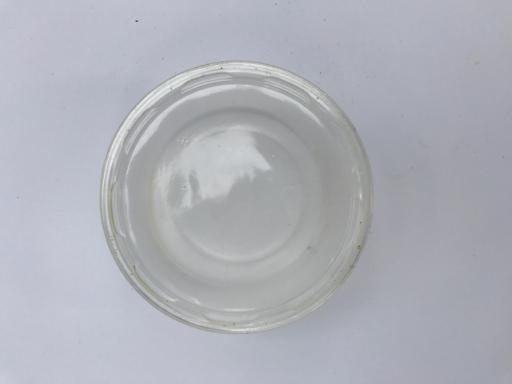

In [ ]:
plastic = list(data_dir.glob('plastic/*'))
PIL.Image.open(str(plastic[0]))

In [ ]:
batch_size = 32
img_ht = 180
img_wd = 180

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(data_dir,validation_split=0.2,subset="training",seed=123,image_size=(img_ht,img_wd),batch_size=batch_size)


Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_ht, img_wd),
  batch_size=batch_size)

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


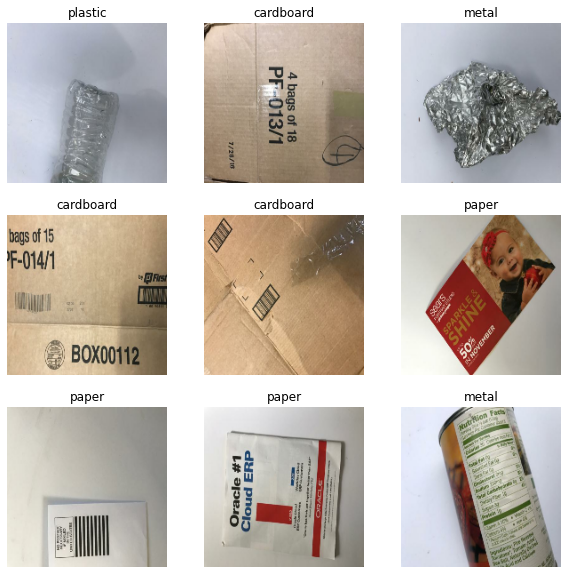

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch , label_batch in train_ds:
  print(image_batch.shape)
  print(label_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalize_ds = train_ds.map(lambda x,y:(normalization_layer(x),y))
image_batch , label_batch = next(iter(normalize_ds))
first_image = image_batch[0]

print(np.min(first_image),np.max(first_image))

0.048497714 0.96248364


NN_Model :

In [ ]:
num_classes = len(class_names)

model = Sequential([
                    layers.Rescaling(1./255,input_shape=(img_ht,img_wd,3)),
                    layers.Conv2D(16,3,padding='same',activation='relu'),
                    layers.MaxPool2D(),
                    layers.Conv2D(32,3,padding='same',activation='sigmoid'),
                    layers.MaxPool2D(),
                    layers.Conv2D(64,3,padding='same',activation='relu'),
                    layers.MaxPooling2D(),
                    layers.Flatten(),
                    layers.Dense(128,activation='relu'),
                    layers.Dense(num_classes)

]
    
)

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs=10
history = model.fit(train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/10
64/64 [==============================] - 13s 64ms/step - loss: 2.2915 - accuracy: 0.2062 - val_loss: 1.7398 - val_accuracy: 0.2455
Epoch 2/10
64/64 [==============================] - 3s 46ms/step - loss: 1.7300 - accuracy: 0.2324 - val_loss: 1.7265 - val_accuracy: 0.2455
Epoch 3/10
64/64 [==============================] - 3s 44ms/step - loss: 1.7285 - accuracy: 0.2260 - val_loss: 1.7325 - val_accuracy: 0.2455
Epoch 4/10
64/64 [==============================] - 3s 44ms/step - loss: 1.7276 - accuracy: 0.2324 - val_loss: 1.7268 - val_accuracy: 0.2455
Epoch 5/10
64/64 [==============================] - 3s 44ms/step - loss: 1.7223 - accuracy: 0.2324 - val_loss: 1.7219 - val_accuracy: 0.2455
Epoch 6/10
64/64 [==============================] - 3s 44ms/step - loss: 1.7185 - accuracy: 0.2324 - val_loss: 1.7106 - val_accuracy: 0.2455
Epoch 7/10
64/64 [==============================] - 3s 45ms/step - loss: 1.7026 - accuracy: 0.2364 - val_loss: 1.6887 - val_accuracy: 0.3208
Epoch 8/10
6

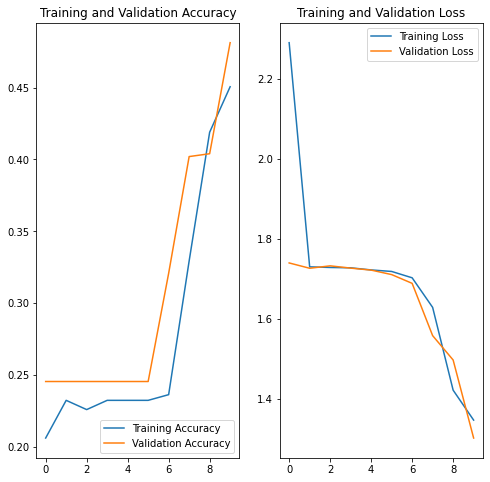

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

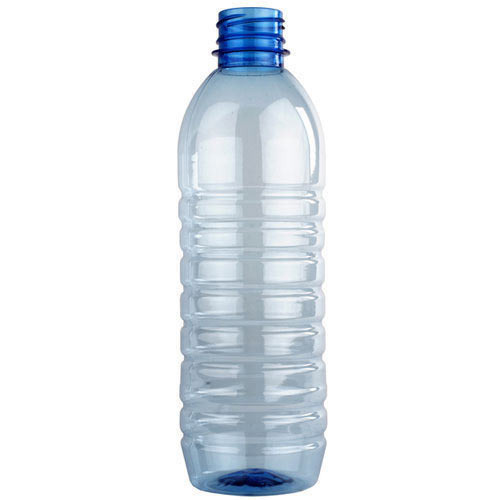

In [ ]:
##plastic = list(data_dir.glob('plastic/*'))
PIL.Image.open(str(sunflower_url))

In [ ]:
#prediction 1
sample = "/content/sample.jpg"
#sample_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_url, target_size=(img_ht, img_wd)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to plastic with a 65.66 percent confidence.


#   Reference Links 🐮
*   https://github.com/anujeet98/plastic-waste-detection
*   https://github.com/IBM/PlasticNet
*   https://github.com/antiplasti/Plastic-Detection-Model
*   https://github.com/garythung/trashnet
*   https://github.com/moneshj/litter-detection-tensorflow/tree/master/dataset
*   https://github.com/VinAIResearch/plasticbag-faster-rcnn



# Extra chatBOT


In [1]:
!pip install chatterbot

     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 1.3 MB 11.6 MB/s 
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 1.4.31
    Uninstalling SQLAlchemy-1.4.31:
      Successfully uninstalled SQLAlchemy-1.4.31


In [2]:
from chatterbot import ChatBot
from chatterbot.trainers import ListTrainer

# Create a new chat bot named monesh
chatbot = ChatBot('monesh')

trainer = ListTrainer(chatbot)

trainer.train([
    "Hi, can I help you?",
    "Sure, I'd like to book a flight to Iceland.",
    "Your flight has been booked."
])

# Get a response to the input text 'I would like to book a flight.'
response = chatbot.get_response('I would like to book a flight.')

print(response)

List Trainer: [####################] 100%
Your flight has been booked.


In [10]:

print(chatbot.get_response('Hi, can I help you?'))

Sure, I'd like to book a flight to Iceland.
